# FAKE JOB DETECTION 

#  1. Importing necessary libraries

In [144]:
import re
import os
import string
import nltk 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import tensorflow as tf
import pickle 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding,Dropout
from keras.layers import LSTM,SimpleRNN,GRU
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from flask import Flask, render_template, request

# 2. Load the dataset

In [145]:
job_ads_df = pd.read_csv('./dataset/fake_job_postings.csv')

In [223]:
job_ads_df.head(5)

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,industry,function,fraudulent
0,marketing intern,US,marketing,food created groundbreaking award winning cook...,food fast growing james beard award winning on...,experience content management system major plu...,unknown,other,internship,unknown,marketing,0
1,customer service cloud video production,NZ,success,second world cloud video production service se...,organised focused vibrant awesome passion cust...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,full time,not applicable,marketing advertising,customer service,0
2,commissioning machinery assistant cma,US,unknown,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement pre commissioning commissioning proc...,unknown,unknown,unknown,unknown,unknown,0
3,account executive washington dc,US,sale,passion improving quality life geography heart...,company esri environmental system research ins...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,full time,mid senior level,computer software,sale,0
4,bill review manager,US,unknown,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualification right license state texasdiploma...,full benefit offered,full time,mid senior level,hospital health care,health care provider,0


# 3. Explore the data

In [147]:
job_ads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [148]:
# Entries in the dataset
total_entries = len(job_ads_df)
total_fake_entries= (job_ads_df['fraudulent'] == 1).sum()
total_real_entries = (job_ads_df['fraudulent'] == 0).sum()

print(f'Total Entries in the dataset    : {total_entries}')
print(f'Total Fraudulent Entries     (1): {total_fake_entries}')
print(f'Total Non-Fraudulent Entries (0): {total_real_entries}')

Total Entries in the dataset    : 17880
Total Fraudulent Entries     (1): 866
Total Non-Fraudulent Entries (0): 17014


In [149]:
# checking for duplicated entries
print(f'There are {job_ads_df.duplicated().sum()} duplicated entries.')

There are 0 duplicated entries.


In [150]:
# Missing values in the dataset
missing_values = job_ads_df.isnull().sum().sort_values(ascending=False)
total_count=job_ads_df.isnull().count()
percent_of_missing = (job_ads_df.isnull().sum() / job_ads_df.isnull().count()*100).sort_values(ascending=False).round(2)
missing_table = pd.concat([missing_values, percent_of_missing], axis=1, keys=['Total missing entries', 'Percentage of missing entries'])
print(missing_table)

                     Total missing entries  Percentage of missing entries
salary_range                         15012                       0.839597
department                           11547                       0.645805
required_education                    8105                       0.453300
benefits                              7210                       0.403244
required_experience                   7050                       0.394295
function                              6455                       0.361018
industry                              4903                       0.274217
employment_type                       3471                       0.194128
company_profile                       3308                       0.185011
requirements                          2695                       0.150727
location                               346                       0.019351
description                              1                       0.000056
job_id                                

<Axes: title={'center': 'Missing Values Heatmap'}>

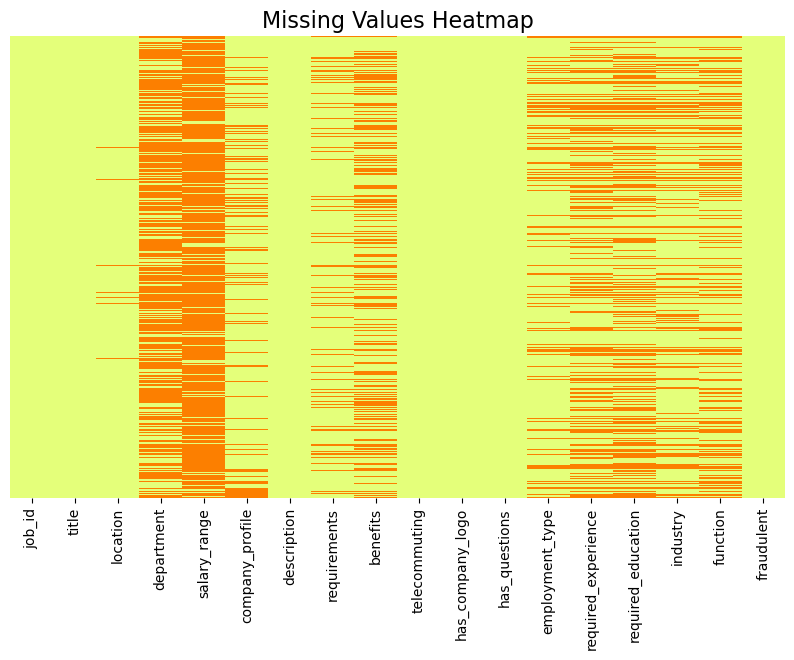

In [151]:
plt.figure(figsize=(10,6))
plt.title("Missing Values Heatmap", fontsize=16)
sns.heatmap(job_ads_df.isnull(), cmap="Wistia", yticklabels=False, cbar=False)

# 4. Data Cleaning  

The data cleaning process consisted of 3 process. Firstly, columns that are missing more than 40% of the data were removed and columns of integer data type were removed as well. Secondly, all the data types were converted to string type. Lastly, handling the missing values, the NaN were replaced with 'unknown'.

### 4.1 Dropping columns

In [152]:
#dropping columns that are missing more than 40% of the data and data type of integer
job_ads_df.drop(columns=['job_id','salary_range','required_education','telecommuting','has_company_logo','has_questions'], inplace=True)
print("Columns left :")
print(job_ads_df.columns)

Columns left :
Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'industry', 'function', 'fraudulent'],
      dtype='object')


### 4.1 Handling data type  

In [153]:
columns_to_chg = ['title','location','department', 'company_profile', 'description',
                   'requirements', 'benefits', 'employment_type', 'required_experience',
                   'industry', 'function']

job_ads_df[columns_to_chg] = job_ads_df[columns_to_chg].astype(str)

###  4.3  Handling missing values 

In [154]:
job_ads_df[columns_to_chg] = job_ads_df[columns_to_chg].replace('nan', 'unknown')
job_ads_df.head(5)

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,unknown,Other,Internship,unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,unknown,unknown,unknown,unknown,unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0


# 5. Target

Looking at the balance of the dataset. The EMSCAD dataset is extremely imbalanced. 

In [155]:
real = job_ads_df['fraudulent'].value_counts().get(0, 0)
real_percent = real / len(job_ads_df)
print(f'Number of Real posts    :        {real}')
print(f'Percentage of Real posts:        {real_percent:.2f}% ')

fraudulent = job_ads_df['fraudulent'].value_counts().get(1, 0)
fraudulent_percent = fraudulent / len(job_ads_df)
print(f'\nNumber of Fraudulent posts    :  {fraudulent}')
print(f'Percentage of Fraudulent posts:  {fraudulent_percent:.2f}% ')

total=real+fraudulent

Number of Real posts    :        17014
Percentage of Real posts:        0.95% 

Number of Fraudulent posts    :  866
Percentage of Fraudulent posts:  0.05% 


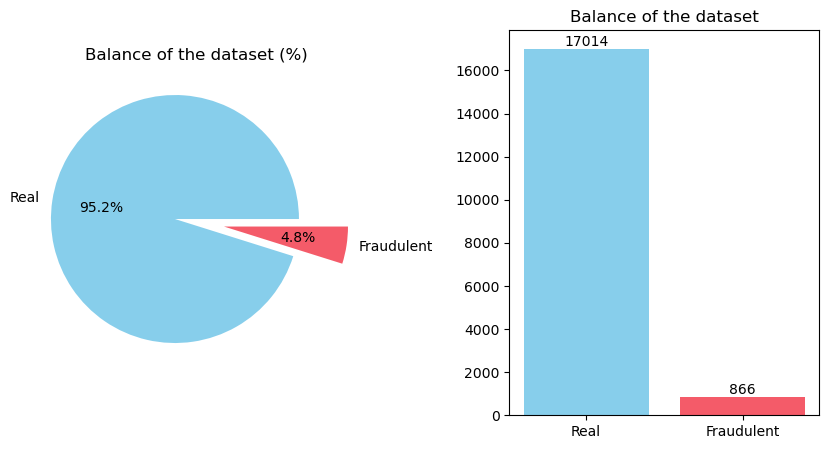

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.5})

axs[0].pie([real,fraudulent], labels=["Real", "Fraudulent"], autopct='%1.1f%%', explode=[0.2, 0.2],colors=['skyblue', '#F45B69'])
axs[0].set_title("Balance of the dataset (%) ")
axs[0].set_ylabel("")

bars = axs[1].bar(["Real", "Fraudulent"], [real, fraudulent], color=['skyblue', '#F45B69'])
for bar, value in zip(bars, [real, fraudulent]):
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(value), ha='center', va='bottom')

axs[1].set_title("Balance of the dataset")
plt.show()


As can be seen in the above diagram, the imbalance is very extreme. A process to handle the imbalance needs to be implemented, I would be using class weight method in the project. 

# 6. Data preprocessing  

The dataset contains categorical columns like employment_type and required_experience. In order to preprocess the dataset I have created a function called 'preprocessing'. The function would take in the data and preprocess it with steps including conversion to small letter, removal of stopwords and special characters, handle contraction words, tokenization and lemmatization

In [157]:
print('Categorical columns are: \n')
print('employment_type:',job_ads_df['employment_type'].unique())
print('required_experience:',job_ads_df['required_experience'].unique())

Categorical columns are: 

employment_type: ['Other' 'Full-time' 'unknown' 'Part-time' 'Contract' 'Temporary']
required_experience: ['Internship' 'Not Applicable' 'unknown' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']


In [158]:
# excluded columns (employment_type,required_experience, title , location) as title and location dosnt need lemmatization
columns_to_lemmatize = ['department','company_profile',
                'description', 'requirements','benefits',
                'industry', 'function']

In [159]:
def process_location(location_column): 
    '''The detailed location is removed, only keep the country'''
    return location_column.split(',')[0].strip()
    
def preprocessing(job_ads_df, text_columns):
    job_df_copy = job_ads_df.copy(deep=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for col in job_df_copy.columns[:-1]:
        for index, text in enumerate(job_df_copy[col]):
            if col != 'location':
                # convert to lowercase except location column
                words = text.lower()
            else:
                # Process the location text
                words = process_location(text) 
                
            # handle contractions
            words = contractions.fix(words)

            # to remove special characters 
            words = re.sub(r'[^A-Za-z\s]',' ', words)
            
            if col in text_columns:
                # tokenization
                tokens = word_tokenize(words)

                processed_words = []
                for tk in tokens:
                    # Remove single-letter words
                    if tk not in stop_words and len(tk) > 1:  # Remove single-letter words
                        processed_words.append(lemmatizer.lemmatize(tk))

                processed_text = ' '.join(processed_words)

                job_df_copy.at[index, col] = processed_text
            else: 
                job_df_copy.at[index, col] = words

    return job_df_copy

In [160]:
job_ads_df['location'] = job_ads_df['location'].apply(process_location)
job_ads_df=preprocessing(job_ads_df,columns_to_lemmatize)
display(job_ads_df.head(3))


,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,industry,function,fraudulent
0,marketing intern,US,marketing,food created groundbreaking award winning cook...,food fast growing james beard award winning on...,experience content management system major plu...,unknown,other,internship,unknown,marketing,0
1,customer service cloud video production,NZ,success,second world cloud video production service se...,organised focused vibrant awesome passion cust...,expect key responsibility communicate client s...,get usthrough part second team gain experience...,full time,not applicable,marketing advertising,customer service,0
2,commissioning machinery assistant cma,US,unknown,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement pre commissioning commissioning proc...,unknown,unknown,unknown,unknown,unknown,0


# 7. Data Visualisation 

Before preprocessing i would like to find abit of pattern that fake job postings have compared to real job positings 

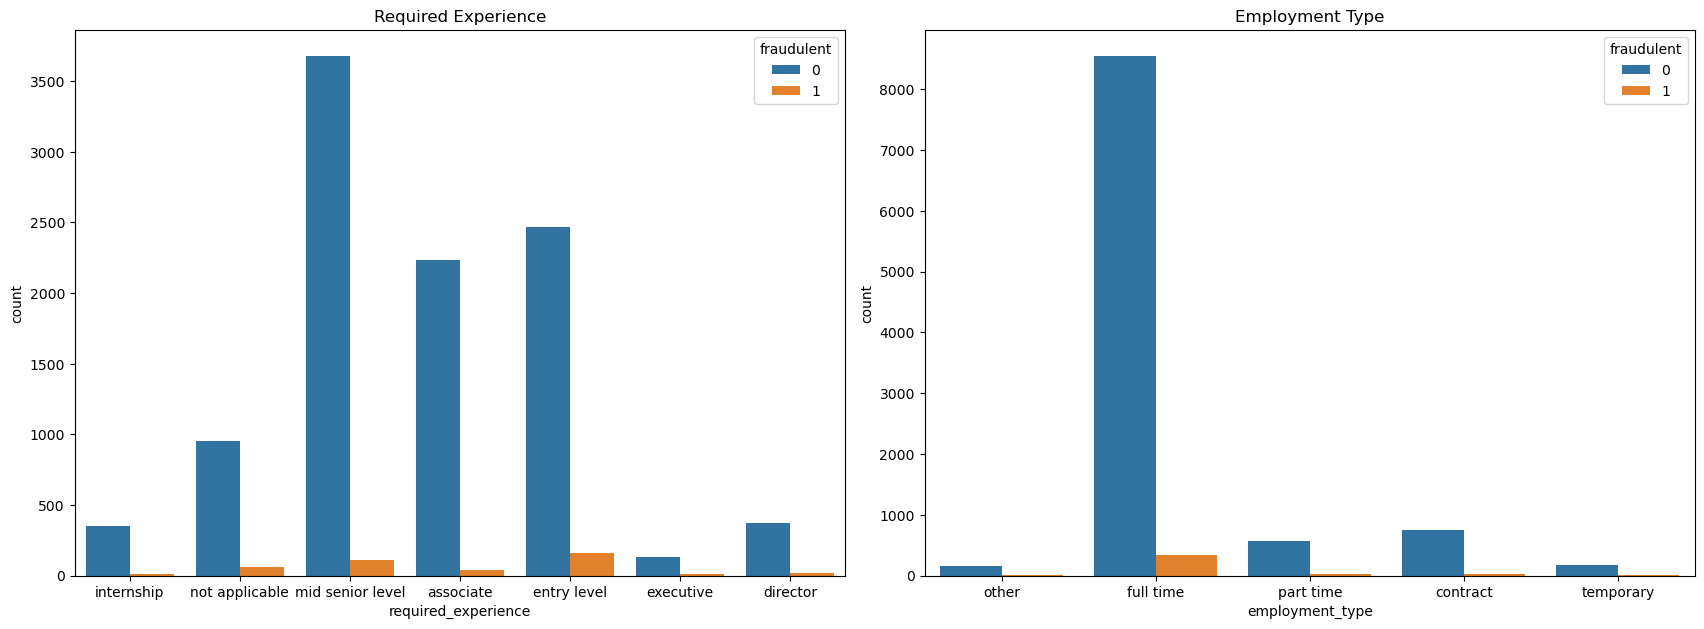

In [161]:
categorical_data = {
    'required_experience': job_ads_df['required_experience'],
    'employment_type': job_ads_df['employment_type'],
    'fraudulent': job_ads_df['fraudulent']
}
categorical_data_df = pd.DataFrame(categorical_data)

filtered_df = categorical_data_df[
    (categorical_data_df['required_experience'] != 'unknown') &
    (categorical_data_df['employment_type'] != 'unknown')
]

categorical_data_df = pd.DataFrame(categorical_data)
fig = plt.figure(figsize=(25, 12))

ax1 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
sns.countplot(data=filtered_df, x='required_experience', hue='fraudulent', ax=ax1)
ax1.set_title('Required Experience')

ax2 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
sns.countplot(data=filtered_df, x='employment_type', hue='fraudulent', ax=ax2)
ax2.set_title('Employment Type')

plt.tight_layout()
plt.show()


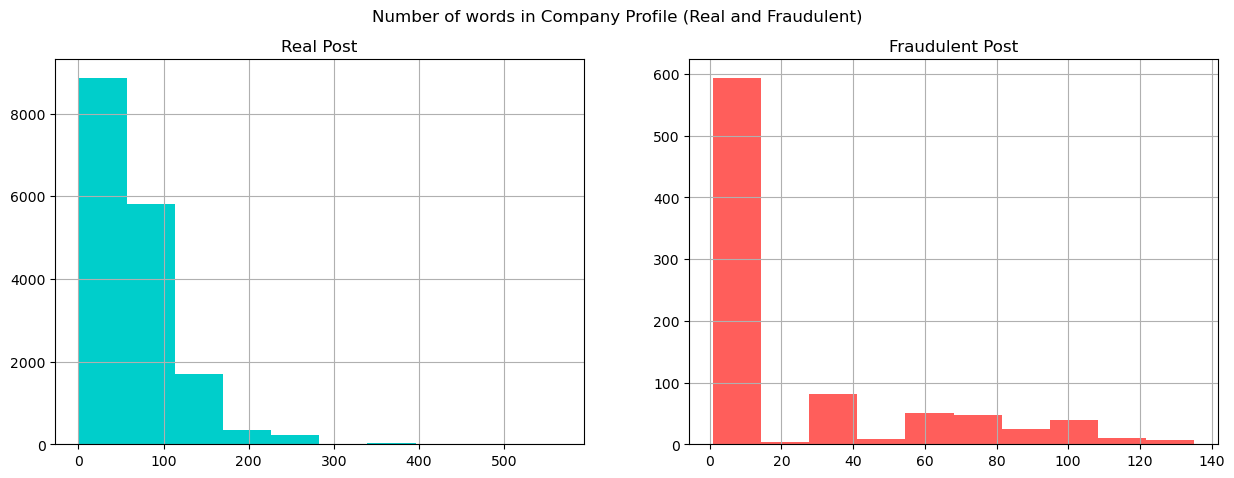

In [162]:
fig, (profile_dia1, profile_dia2) = plt.subplots(ncols=2, figsize=(15, 5))

num_real = job_ads_df[job_ads_df["fraudulent"] == 0]['company_profile'].str.split().map(lambda x: len(x))
profile_dia1.hist(num_real, color='#00CECB')
profile_dia1.set_title('Real Post')
profile_dia1.grid(True) 

num_fraudulent = job_ads_df[job_ads_df["fraudulent"] == 1]['company_profile'].str.split().map(lambda x: len(x))
profile_dia2.hist(num_fraudulent,color='#FF5E5B')
profile_dia2.set_title('Fraudulent Post')
profile_dia2.grid(True) 

# profile_dia2.set_ylim(profile_dia1.get_ylim())

fig.suptitle('Number of words in Company Profile (Real and Fraudulent)')

plt.show()


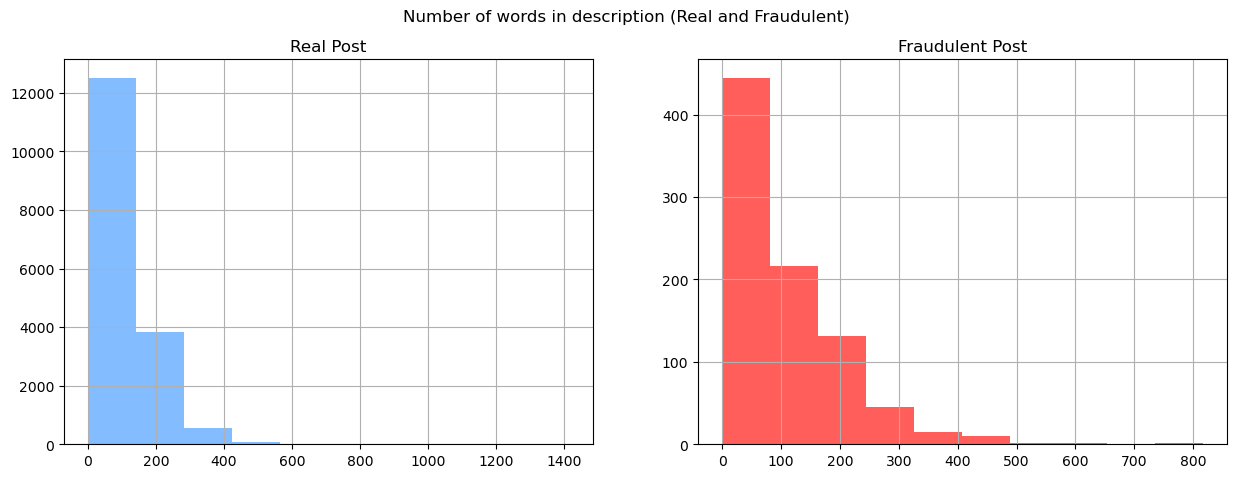

In [163]:
fig, (des_dia1, des_dia2) = plt.subplots(ncols=2, figsize=(15, 5))

num_real = job_ads_df[job_ads_df["fraudulent"] ==0 ]['description'].str.split().map(lambda x: len(x))
des_dia1.hist(num_real, color='#83BCFF')
des_dia1.set_title('Real Post')
des_dia1.grid(True) 

num_fraudulent = job_ads_df[job_ads_df["fraudulent"] == 1]['description'].str.split().map(lambda x: len(x))
des_dia2.hist(num_fraudulent,color='#FF5E5B')
des_dia2.set_title('Fraudulent Post')
des_dia2.grid(True) 

# des_dia2.set_ylim(ax1.get_ylim())

fig.suptitle('Number of words in description (Real and Fraudulent)')

plt.show()


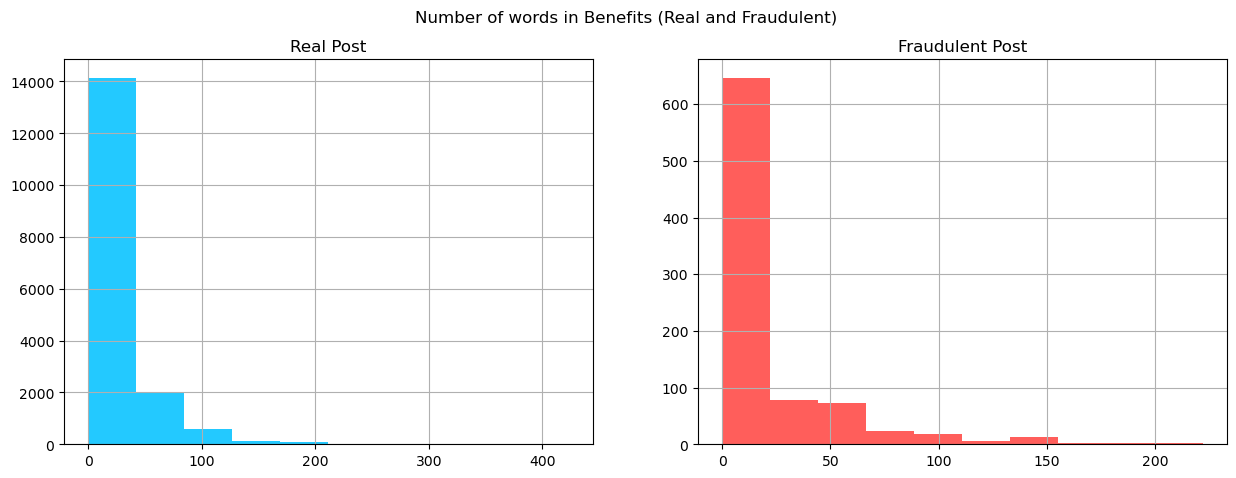

In [164]:
fig, (bene_dia1, bene_dia2) = plt.subplots(ncols=2, figsize=(15, 5))

num_real = job_ads_df[job_ads_df["fraudulent"] == 0]['benefits'].str.split().map(lambda x: len(x))
bene_dia1.hist(num_real, color='#23C9FF')
bene_dia1.set_title('Real Post')
bene_dia1.grid(True) 

num_fraudulent = job_ads_df[job_ads_df["fraudulent"] == 1]['benefits'].str.split().map(lambda x: len(x))
bene_dia2.hist(num_fraudulent,color='#FF5E5B')
bene_dia2.set_title('Fraudulent Post')
bene_dia2.grid(True) 

# des_dia2.set_ylim(ax1.get_ylim())

fig.suptitle('Number of words in Benefits (Real and Fraudulent)')

plt.show()


In [165]:
# bar graph for location

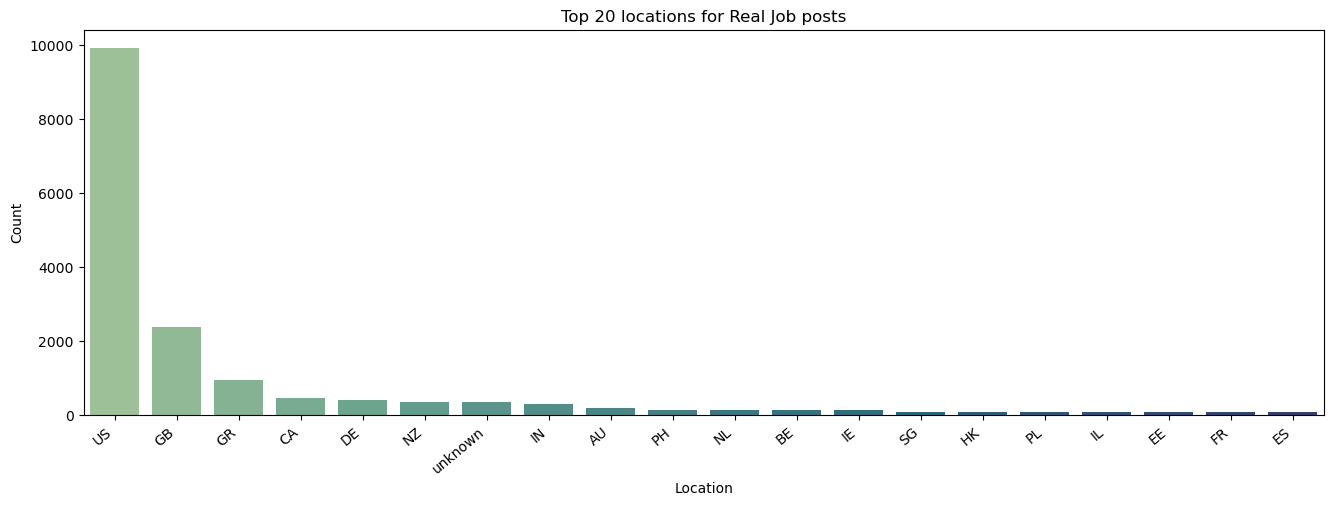

In [166]:
real_job_locations = job_ads_df[job_ads_df['fraudulent'] == 0]['location']

# Count the frequency of each unique location
location_counts = real_job_locations.value_counts().reset_index()
location_counts = location_counts[location_counts['location'] != 'unknown']
location_counts.columns = ['Location', 'Count']

# Plotting
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=location_counts.head(20), x="Location", y="Count", palette="crest")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylabel='Count')
plt.title('Top 20 locations for Real Job posts')
plt.show()

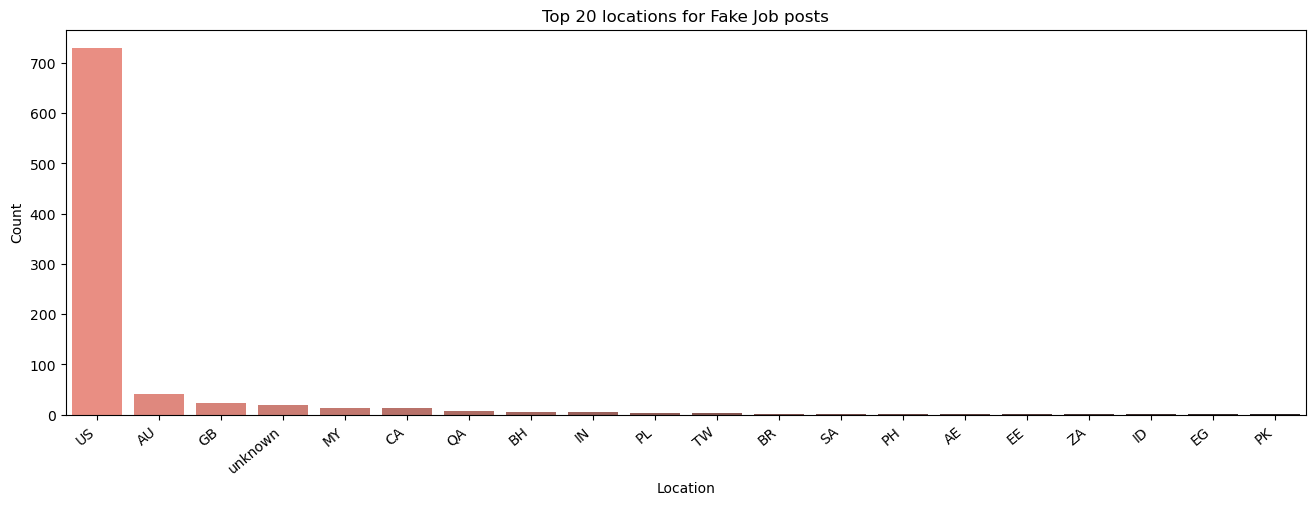

In [167]:
real_job_locations = job_ads_df[job_ads_df['fraudulent'] == 1]['location']

# Count the frequency of each unique location
location_counts = real_job_locations.value_counts().reset_index()
location_counts = location_counts[location_counts['location'] != 'unknown']
location_counts.columns = ['Location', 'Count']

# Plotting
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=location_counts.head(20), x="Location", y="Count", palette="dark:salmon_r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylabel='Count')
plt.title('Top 20 locations for Fake Job posts')
plt.show()

In [168]:
## wordCloud

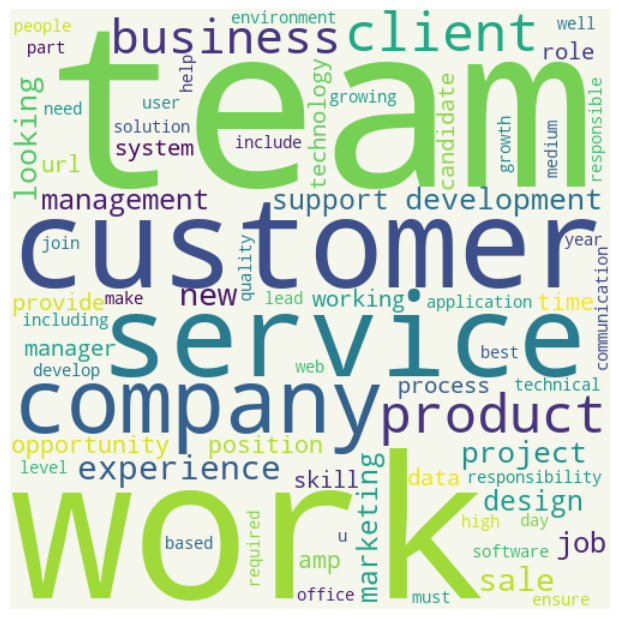

In [169]:
real_ads = job_ads_df[job_ads_df['fraudulent'] == 0]['description']
job_description_real = ' '.join(real_ads)

wordcloud = WordCloud(width=500, height=500,
                      random_state=60,
                      background_color='#f5f7ed',
                      min_font_size=12,
                      collocations=False).generate(job_description_real)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

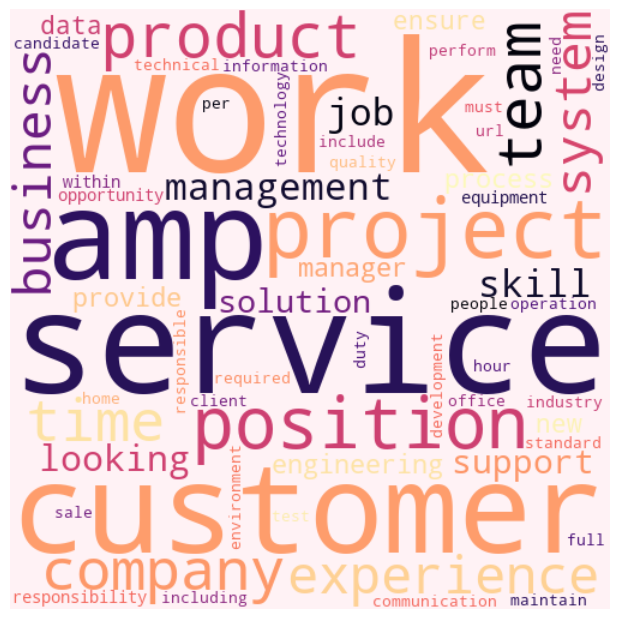

In [170]:
fraudulent_ads = job_ads_df[job_ads_df['fraudulent'] == 1]['description']
job_description_fake = ' '.join(fraudulent_ads)
wordcloud = WordCloud(width=500, height=500,
                      random_state=60,
                      background_color='#FFF2F5',
                      min_font_size=12,
                      collocations=False,
                      colormap='magma').generate(job_description_fake)

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

### Split to test and train set

In [171]:
my_seed = 42

In [172]:
combined_job_df=pd.DataFrame()
combined_job_df['combined_columns']=job_ads_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
combined_job_df=pd.concat([combined_job_df, job_ads_df['fraudulent']], axis=1)
print(combined_job_df.sample(5))

                                        combined_columns  fraudulent
7991   user experience  ux  designer CA iw work imagi...           0
16161  senior quality assurance engineer  remote tele...           0
15394  prototyping engineer US workshop vayu build af...           0
8376   web developer SG unknown doctor geek understan...           0
5920   user support analyst  GB operation import io f...           0


In [173]:
X_train, X_test, y_train, y_test = train_test_split(combined_job_df['combined_columns'], 
                                                    combined_job_df['fraudulent'], 
                                                    test_size=0.2, 
                                                    random_state=my_seed)

In [174]:
#preparing for class weight 
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print('Class weights: ',class_weights)

Class weights:  {0: 0.5251486893310816, 1: 10.440875912408758}


## Text feature extraction : TF_IDF 

In [175]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf= tfidf_vectorizer.transform(X_test)

The train set is large in scale, as conducting k cross validation to such large data is computationally burden so would further divide the train set to smaller train set and validation set for hyperparameter tunning of models.

In [176]:
#spliting train set to obtain smaller train set for hyperparameter tunninng
X_small_train,X_validation, y_small_train, y_validation= train_test_split(X_train_tfidf,
                                                                          y_train,
                                                                          test_size=0.2,
                                                                          random_state=my_seed)

In [177]:
print('X Train set shape :',X_train.shape,'\ny Train set shape :',y_train.shape)
print('\nX Validation set shape :',X_validation.shape,'\ny Validation set shape :',y_validation.shape)
print('\nX Test set shape :',X_test_tfidf.shape,'\ny Test set shape :',y_test.shape)

X Train set shape : (14304,) 
y Train set shape : (14304,)

X Validation set shape : (2861, 2378756) 
y Validation set shape : (2861,)

X Test set shape : (3576, 2378756) 
y Test set shape : (3576,)


## 8.  Setting Baseline

In [178]:
# Create a baseline random classifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=my_seed)
dummy_clf.fit(X_train_tfidf, y_train)
dummy_clf_predict=dummy_clf.predict(X_test_tfidf)

In [179]:
accuracy = accuracy_score(y_test, dummy_clf_predict)
print('Accuracy  : {:.2%}'.format(accuracy))

precision = precision_score(y_test, dummy_clf_predict)
print('Precision : {:.2%}'.format(precision))

recall = recall_score(y_test, dummy_clf_predict)
print('Recall    : {:.2%}'.format(recall))

f1 = f1_score(y_test, dummy_clf_predict)
print('F1-score  : {:.2%}'.format(f1))

Accuracy  : 90.55%
Precision : 5.14%
Recall    : 4.97%
F1-score  : 5.06%


In [180]:
baseline_log_report = classification_report(y_test, dummy_clf_predict, target_names=['Non-Fraudulent','Fraudulent'])
print(baseline_log_report)

                precision    recall  f1-score   support

Non-Fraudulent       0.95      0.95      0.95      3395
    Fraudulent       0.05      0.05      0.05       181

      accuracy                           0.91      3576
     macro avg       0.50      0.50      0.50      3576
  weighted avg       0.90      0.91      0.90      3576



## 9.  Machine learning Models
<ul>
    <li> Logistic regression</li>
    <li> Naive Bayes</li>
    <li> SVM</li>
</ul>

### Finding best hyperparameters with K cross validation

In [1]:
# hyperparameters for each model 
logistic_params= {
    'solver' :['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C' :[100, 10, 1.0, 0.1, 0.01]
}
svm_params= {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
} 

naive_params={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]} 

In [40]:
logistic = LogisticRegression(random_state=my_seed, max_iter=100000)

logistic_grid = RandomizedSearchCV(logistic, logistic_params, cv=3,n_iter=10, scoring='accuracy')
logistic_grid.fit(X_validation, y_validation)

logistic_best_param = logistic_grid.best_params_

print("Logistic Regression:")
print("The best parameters are %s with an accuracy of %0.4f"
      % (logistic_best_param, logistic_grid.best_score_))

Logistic Regression:
The best parameters are {'solver': 'liblinear', 'penalty': 'l2', 'C': 100} with an accuracy of 0.9710


In [41]:
svm = SVC(random_state=my_seed)

svm_grid = RandomizedSearchCV(svm, svm_params, cv=3, scoring='accuracy',n_iter=10)
svm_grid.fit(X_validation, y_validation)

svm_best_param = svm_grid.best_params_

print('Support Vector Machines (SVM) (TF_IDF) :')
print("The best parameters are %s with an accuracy of %0.4f"
      % (svm_best_param,svm_grid.best_score_))

Support Vector Machines (SVM) (TF_IDF) :
The best parameters are {'gamma': 0.01, 'C': 1000} with an accuracy of 0.9745


In [42]:
naive = MultinomialNB()

naive_grid= RandomizedSearchCV(naive, naive_params, cv=3,n_iter=8,scoring='accuracy')
naive_grid.fit(X_validation, y_validation)

naive_best_param=naive_grid.best_params_

print('Multinomial Naive Bayes:')
print("The best parameters are %s with an accuracy of %0.4f"
      % (naive_best_param,naive_grid.best_score_))

Multinomial Naive Bayes:
The best parameters are {'alpha': 0.1} with an accuracy of 0.9591


In [79]:
model_performance=pd.DataFrame()

def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Evaluation Metrics:")
    
    print(f"Accuracy   : {accuracy * 100:.02f}%")
    print(f"Precision  : {precision * 100:.02f}%")
    print(f"Recall     : {recall * 100:.02f}%")
    print(f"F1 Score   : {f1 * 100:.02f}%")
    
    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    evaluation_metrics = {
        'Classification models': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    global model_performance
    model_performance = pd.concat([model_performance, pd.DataFrame([evaluation_metrics])], ignore_index=True)

### Recreate Machine learning models with best hyperparameters then performance Analysis

Evaluation Metrics:
Accuracy   : 99.02%
Precision  : 98.03%
Recall     : 82.32%
F1 Score   : 89.49%


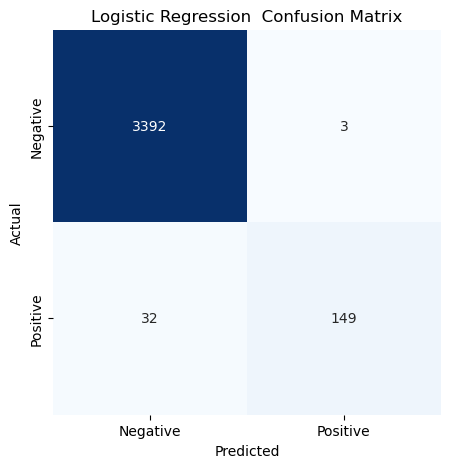

In [45]:
logistic_model = LogisticRegression(random_state=my_seed,
                                    class_weight=class_weights,
                                    **logistic_best_param,max_iter=100000,)
logistic_model.fit(X_train_tfidf, y_train)
log_y_pred = logistic_model.predict(X_test_tfidf)

log_performance = evaluate_model(y_test,log_y_pred,'Logistic Regression ')

Evaluation Metrics:
Accuracy   : 98.80%
Precision  : 99.29%
Recall     : 76.80%
F1 Score   : 86.60%


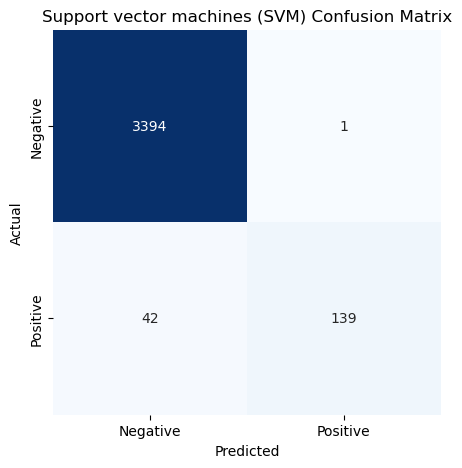

In [46]:
svm_model = SVC(random_state=my_seed,
                class_weight=class_weights,
                **svm_best_param)
svm_model.fit(X_train_tfidf, y_train)
svm_y_pred = svm_model.predict(X_test_tfidf)

svm_performance = evaluate_model(y_test,svm_y_pred,'Support vector machines (SVM)')

Evaluation Metrics:
Accuracy   : 97.96%
Precision  : 100.00%
Recall     : 59.67%
F1 Score   : 74.74%


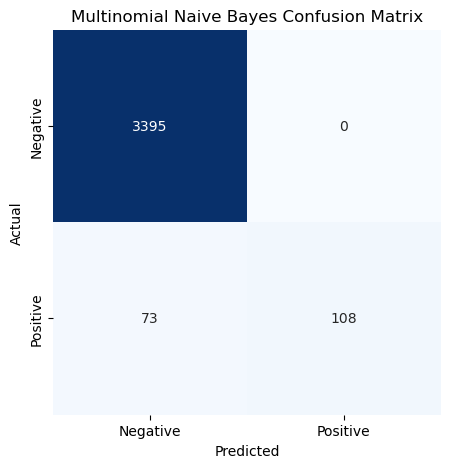

In [47]:
naive_model = MultinomialNB(**naive_best_param)
naive_model.fit(X_train_tfidf, y_train)
naive_y_pred = naive_model.predict(X_test_tfidf)

naive_performance = evaluate_model(y_test,naive_y_pred,'Multinomial Naive Bayes')

In [48]:
display(model_performance)

,Classification models,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.990213,0.980263,0.823204,0.894895
1,Support vector machines (SVM),0.987975,0.992857,0.767956,0.866044
2,Multinomial Naive Bayes,0.979586,1.000000,0.596685,0.747405


## 11. Deep learning models 

- LSTM 
- RNN 
- GRE

### Processing the data for deep learning models
- tokenisation 
- conversion to sequence 
- pad sequence

In [207]:
# Tokenize the textual words
oov_tok = '<oov>'
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
voc_size= len(tokenizer.word_index) + 1
print('Total vocabulary size: ',voc_size)

# Text converted to sequence
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Sequence length
sequence_length = 300

X_train_padded = pad_sequences(X_train_sequences, maxlen=sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=sequence_length, padding='post', truncating='post')

Total vocabulary size:  82174


In [42]:
print('X_train_padded size: ',X_train_padded.shape,' y_train size: ',y_train.shape)
print('X_test_padded size: ',X_test_padded.shape,' y_test size: ',y_test.shape)

X_train_padded size:  (14304, 300)  y_train size:  (14304,)
X_test_padded size:  (3576, 300)  y_test size:  (3576,)


### Finding best hyperparameters for deep learning models 

In [43]:
#splitting the train set to smaller train set and validation set 
x_train2, x_val, y_train2, y_val = train_test_split(X_train_padded, y_train,
                                                  test_size=0.2,
                                                  random_state=my_seed)

In [44]:
print('X Train set shape :',x_train2.shape,'\ny Train set shape :',y_train2.shape)
print('\nX Validation set shape :',x_val.shape,'\ny Validation set shape :',y_val.shape)

X Train set shape : (11443, 300) 
y Train set shape : (11443,)

X Validation set shape : (2861, 300) 
y Validation set shape : (2861,)


In [46]:
tf.random.set_seed(my_seed)
random.seed(my_seed)

# hyperparameters
hidden_layers=[1, 2]
neurons= [16, 32, 64]
dropout_rate= [0.25, 0.5]
param_grid = dict(model__hidden_layers=hidden_layers,
                  model__neurons=neurons,
                  model__dropout_rate=dropout_rate)

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]

In [64]:
def create_lstm_model(hidden_layers, neurons, dropout_rate):    
    lstm_model = Sequential()
    lstm_model.add(Embedding(voc_size, sequence_length, input_length=sequence_length))
    lstm_model.add(LSTM(neurons))
    if hidden_layers> 0: 
        for layer in range(hidden_layers): 
            if neurons is not None: 
                lstm_model.add(Dense(units=neurons,activation='relu'))
            if dropout_rate is not None: 
                lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics='accuracy')
    return lstm_model

In [57]:
lstm_randomcv = KerasClassifier(model=create_lstm_model)
grid = RandomizedSearchCV(estimator=lstm_randomcv,
                          param_distributions=param_grid,
                          cv=3, 
                          random_state=my_seed,
                          scoring='accuracy')
grid_result = grid.fit(x_val, y_val,epochs=30, callbacks=callbacks, verbose=0)
lstm_best_param=grid_result.best_params_
print("Best: %f using %s" % (grid_result.best_score_,lstm_best_param))


30/30 [==============================] - 1s 22ms/step
Best: 0.980079 using {"model__neurons": 32, "model__hidden_layers": 2, "model__dropout_rate": 0.25}



In [83]:
# RNN
def create_rnn_model(hidden_layers, neurons, dropout_rate):    
    rnn_model = Sequential()
    rnn_model.add(Embedding(voc_size, sequence_length, input_length=sequence_length))
    rnn_model.add(SimpleRNN(neurons))
    if hidden_layers> 0: 
        for layer in range(hidden_layers): 
            if neurons is not None: 
                rnn_model.add(Dense(neurons,activation='relu'))
            if dropout_rate is not None: 
                rnn_model.add(Dropout(dropout_rate))
    rnn_model.add(Dense(1,activation='sigmoid'))
    rnn_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics='accuracy')
    return rnn_model

In [32]:
rnn_randomcv = KerasClassifier(model=create_rnn_model)
grid2 = RandomizedSearchCV(estimator=rnn_randomcv,
                          param_distributions=param_grid,
                          cv=3, 
                          random_state=my_seed,
                          scoring='accuracy')
grid_result2 = grid2.fit(x_val, y_val,epochs=30, callbacks=callbacks,verbose=0)
rnn_best_param=grid_result2.best_params_
print("Best: %f using %s" % (grid_result2.best_score_,rnn_best_param))

30/30 [==============================] - 0s 13ms/step
Best: 0.951413 using {'model__neurons': 16, 'model__hidden_layers': 1, 'model__dropout_rate': 0.25}


In [124]:
# GRU
def create_gru_model(hidden_layers, neurons, dropout_rate):    
    gru_model = Sequential()
    gru_model.add(Embedding(voc_size,sequence_length,input_length=sequence_length))
    gru_model.add(GRU(neurons))
    if hidden_layers> 0: 
        for layer in range(hidden_layers): 
            if neurons is not None: 
                gru_model.add(Dense(neurons,activation='relu'))
            if dropout_rate is not None: 
                gru_model.add(Dropout(dropout_rate))
    gru_model.add(Dense(1,activation='sigmoid'))
    gru_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics='accuracy')
    return gru_model

In [60]:
gru_randomcv= KerasClassifier(model=create_gru_model)
grid3= RandomizedSearchCV(estimator=gru_randomcv,
                          param_distributions=param_grid,
                          cv=3,
                          random_state=my_seed,
                          scoring='accuracy')
grid_result3= grid3.fit(x_val, y_val,epochs=30, callbacks=callbacks,verbose=0)
gru_best_param=grid_result3.best_params_
print("Best: %f using %s" % (grid_result3.best_score_,gru_best_param))



30/30 [==============================] - 1s 27ms/step
Best: 0.986369 using {'model__neurons': 16, 'model__hidden_layers': 1, 'model__dropout_rate': 0.25}



### Recreate Machine learning models with best hyperparameters then performance Analysis

In [72]:
def plot_metrics(history, title=''):
    epochs = range(1, len(history['loss']) + 1) 
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(10, 8)) 
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(epochs, history[metric], label='Train')
        plt.plot(epochs, history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
            plt.title('Model Loss')
        else:
            plt.ylim([0, 1])
            plt.title('Model Accuracy')
        plt.legend()

# LSTM

In [74]:
lstm_model=create_lstm_model(lstm_best_param['model__hidden_layers'],
                              lstm_best_param['model__neurons'],
                              lstm_best_param['model__dropout_rate'])
print(lstm_model.summary())


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 300, 300)          24652200  
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dense_80 (Dense)            (None, 32)                1056      
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                                 
 dense_81 (Dense)            (None, 32)                1056      
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_82 (Dense)            (None, 1)               

In [75]:
lstm_callbacks = [EarlyStopping(monitor='val_loss',restore_best_weights=True, verbose=1, patience=3)]

In [76]:
lstm_history = lstm_model.fit(X_train_padded,
                              y_train,
                              epochs=30,
                              validation_data=(x_val, y_val),
                              verbose=1,
                              callbacks=lstm_callbacks,
                              class_weight=class_weights)

Epoch 1/30
447/447 [==============================] - 42s 92ms/step - loss: 0.6862 - accuracy: 0.6141 - val_loss: 0.6986 - val_accuracy: 0.3890
Epoch 2/30
447/447 [==============================] - 39s 87ms/step - loss: 0.6726 - accuracy: 0.4937 - val_loss: 0.5606 - val_accuracy: 0.4900
Epoch 3/30
447/447 [==============================] - 41s 91ms/step - loss: 0.5213 - accuracy: 0.7227 - val_loss: 0.1484 - val_accuracy: 0.9486
Epoch 4/30
447/447 [==============================] - 43s 96ms/step - loss: 0.2781 - accuracy: 0.9636 - val_loss: 0.0390 - val_accuracy: 0.9923
Epoch 5/30
447/447 [==============================] - 44s 98ms/step - loss: 0.1643 - accuracy: 0.9762 - val_loss: 0.0160 - val_accuracy: 0.9958
Epoch 6/30
447/447 [==============================] - 41s 93ms/step - loss: 0.1980 - accuracy: 0.9693 - val_loss: 0.0071 - val_accuracy: 0.9990
Epoch 7/30
447/447 [==============================] - 42s 94ms/step - loss: 0.1116 - accuracy: 0.9803 - val_loss: 0.0077 - val_accuracy:

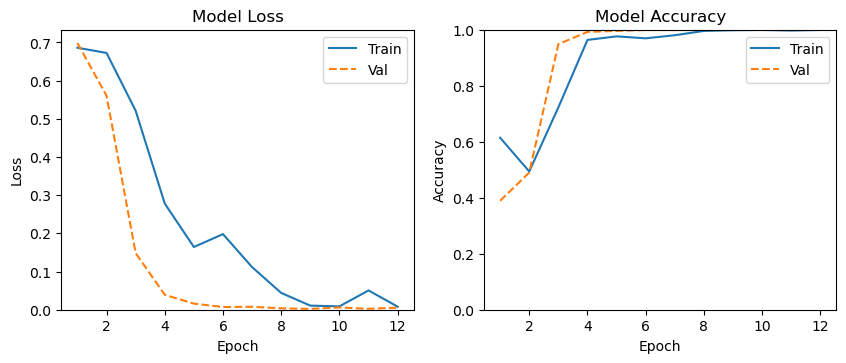

In [77]:
lstm_history_df = pd.DataFrame(lstm_history.history)
plot_metrics(lstm_history_df)                         

112/112 [==============================] - 2s 18ms/step
Evaluation Metrics:
Accuracy   : 99.08%
Precision  : 97.44%
Recall     : 83.98%
F1 Score   : 90.21%


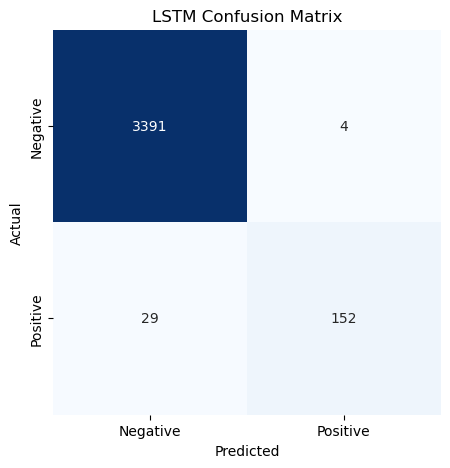

In [80]:
lstm_y_pred=lstm_model.predict(X_test_padded)
lstm_y_pred_class= (lstm_y_pred > 0.5).astype(int)
evaluate_model(y_test,lstm_y_pred_class,'LSTM')

In [81]:
print(classification_report(y_test, lstm_y_pred_class,  labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3395
           1       0.97      0.84      0.90       181

    accuracy                           0.99      3576
   macro avg       0.98      0.92      0.95      3576
weighted avg       0.99      0.99      0.99      3576



# RNN

In [117]:
rnn_model =create_rnn_model(rnn_best_param['model__hidden_layers'],
                              rnn_best_param['model__neurons'],
                              rnn_best_param['model__dropout_rate'])
print(rnn_model.summary())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 300, 300)          24652200  
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 16)                5072      
                                                                 
 dense_95 (Dense)            (None, 16)                272       
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_96 (Dense)            (None, 1)                 17        
                                                                 
Total params: 24657561 (94.06 MB)
Trainable params: 24657561 (94.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [118]:
rnn_callbacks = [EarlyStopping(monitor='val_loss',restore_best_weights=True, verbose=1, patience=4)]

In [119]:
rnn_history = rnn_model.fit(X_train_padded,
                            y_train,
                            epochs=30,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=rnn_callbacks,
                            class_weight=class_weights)

Epoch 1/30
447/447 [==============================] - 32s 70ms/step - loss: 0.6911 - accuracy: 0.4604 - val_loss: 0.7091 - val_accuracy: 0.3789
Epoch 2/30
447/447 [==============================] - 31s 69ms/step - loss: 0.6531 - accuracy: 0.4361 - val_loss: 0.5675 - val_accuracy: 0.4062
Epoch 3/30
447/447 [==============================] - 31s 69ms/step - loss: 0.5929 - accuracy: 0.4216 - val_loss: 0.5311 - val_accuracy: 0.4089
Epoch 4/30
447/447 [==============================] - 31s 69ms/step - loss: 0.5678 - accuracy: 0.4727 - val_loss: 0.5029 - val_accuracy: 0.5107
Epoch 5/30
447/447 [==============================] - 31s 69ms/step - loss: 0.5449 - accuracy: 0.5845 - val_loss: 0.6238 - val_accuracy: 0.3988
Epoch 6/30
447/447 [==============================] - 31s 69ms/step - loss: 0.5039 - accuracy: 0.5139 - val_loss: 0.3744 - val_accuracy: 0.9678
Epoch 7/30
447/447 [==============================] - 31s 70ms/step - loss: 0.4999 - accuracy: 0.5415 - val_loss: 0.4082 - val_accuracy:

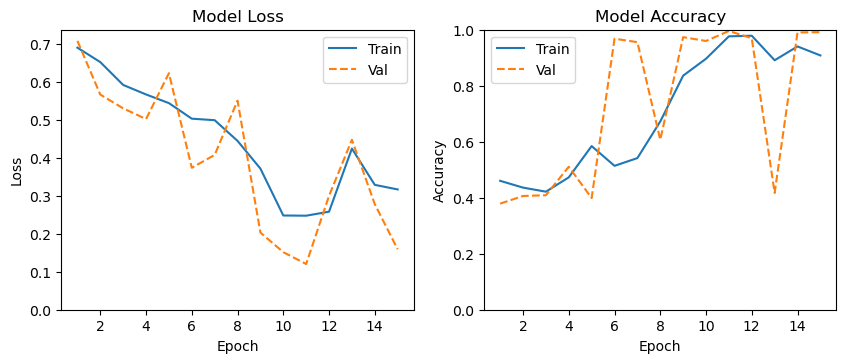

In [120]:
rnn_history_df = pd.DataFrame(rnn_history.history)
plot_metrics(rnn_history_df)

112/112 [==============================] - 1s 10ms/step
Evaluation Metrics:
Accuracy   : 96.06%
Precision  : 58.85%
Recall     : 73.48%
F1 Score   : 65.36%


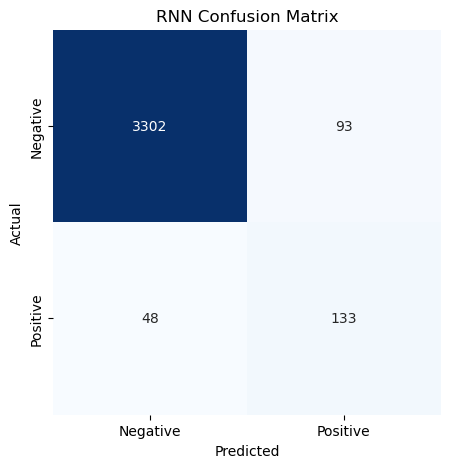

In [121]:
rnn_y_pred=rnn_model.predict(X_test_padded)
rnn_y_pred_class= (rnn_y_pred > 0.5).astype(int)
evaluate_model(y_test,rnn_y_pred_class,'RNN')

In [122]:
print(classification_report(y_test, rnn_y_pred_class,  labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3395
           1       0.59      0.73      0.65       181

    accuracy                           0.96      3576
   macro avg       0.79      0.85      0.82      3576
weighted avg       0.97      0.96      0.96      3576



# GRU

In [126]:
gru_model =create_gru_model(gru_best_param['model__hidden_layers'],
                              gru_best_param['model__neurons'],
                              gru_best_param['model__dropout_rate'])
print(gru_model.summary())

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 300, 300)          24652200  
                                                                 
 gru_31 (GRU)                (None, 16)                15264     
                                                                 
 dense_97 (Dense)            (None, 16)                272       
                                                                 
 dropout_57 (Dropout)        (None, 16)                0         
                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 24667753 (94.10 MB)
Trainable params: 24667753 (94.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [127]:
gru_callbacks = [EarlyStopping(monitor='val_loss',restore_best_weights=True, verbose=1, patience=2)]

In [128]:
gru_history = gru_model.fit(X_train_padded,
                              y_train,
                              epochs=20,
                              validation_data=(x_val, y_val),
                              verbose=1,
                              callbacks=gru_callbacks,
                              class_weight=class_weights)

Epoch 1/20
447/447 [==============================] - 38s 80ms/step - loss: 0.6890 - accuracy: 0.5710 - val_loss: 0.6932 - val_accuracy: 0.3708
Epoch 2/20
447/447 [==============================] - 35s 79ms/step - loss: 0.6785 - accuracy: 0.4081 - val_loss: 0.6376 - val_accuracy: 0.3820
Epoch 3/20
447/447 [==============================] - 36s 80ms/step - loss: 0.6592 - accuracy: 0.4492 - val_loss: 0.6543 - val_accuracy: 0.3852
Epoch 4/20
447/447 [==============================] - 36s 81ms/step - loss: 0.4117 - accuracy: 0.7159 - val_loss: 0.0315 - val_accuracy: 0.9930
Epoch 5/20
447/447 [==============================] - 37s 83ms/step - loss: 0.0961 - accuracy: 0.9839 - val_loss: 0.0835 - val_accuracy: 0.9724
Epoch 6/20
447/447 [==============================] - 37s 83ms/step - loss: 0.0629 - accuracy: 0.9889 - val_loss: 0.0095 - val_accuracy: 0.9979
Epoch 7/20
447/447 [==============================] - 37s 83ms/step - loss: 0.0357 - accuracy: 0.9953 - val_loss: 0.0044 - val_accuracy:

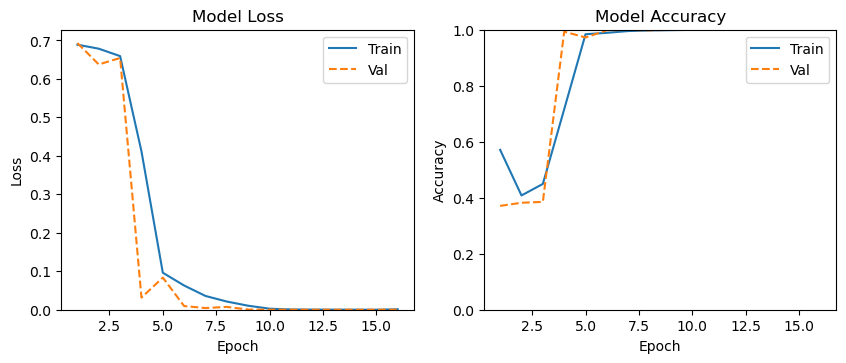

In [129]:
gru_history_df = pd.DataFrame(gru_history.history)
plot_metrics(gru_history_df)

112/112 [==============================] - 2s 16ms/step
Evaluation Metrics:
Accuracy   : 98.83%
Precision  : 87.57%
Recall     : 89.50%
F1 Score   : 88.52%


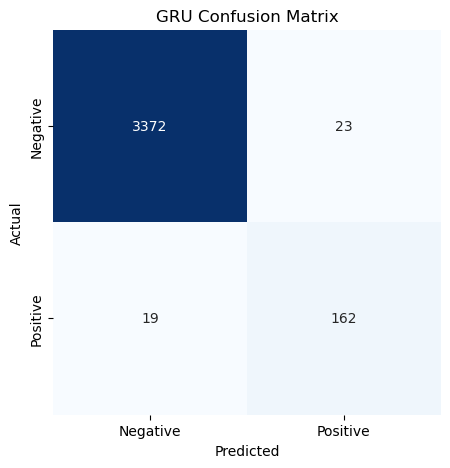

In [130]:
gru_y_pred=gru_model.predict(X_test_padded)
gru_y_pred_class= (gru_y_pred > 0.5).astype(int)
evaluate_model(y_test,gru_y_pred_class,'GRU')

In [131]:
print(classification_report(y_test, gru_y_pred_class,  labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.88      0.90      0.89       181

    accuracy                           0.99      3576
   macro avg       0.94      0.94      0.94      3576
weighted avg       0.99      0.99      0.99      3576



# Comparing the performance of all the models 

In [182]:
display(model_performance)

,Classification models,Accuracy,Precision,Recall,F1 Score
0,Logistic,0.990213,0.980263,0.823204,0.894895
1,SVM,0.987975,0.992857,0.767956,0.866044
2,Naive,0.979586,1.000000,0.596685,0.747405
3,LSTM,0.990772,0.974359,0.839779,0.902077
4,RNN,0.960570,0.588496,0.734807,0.653563
5,GRU,0.988255,0.875676,0.895028,0.885246


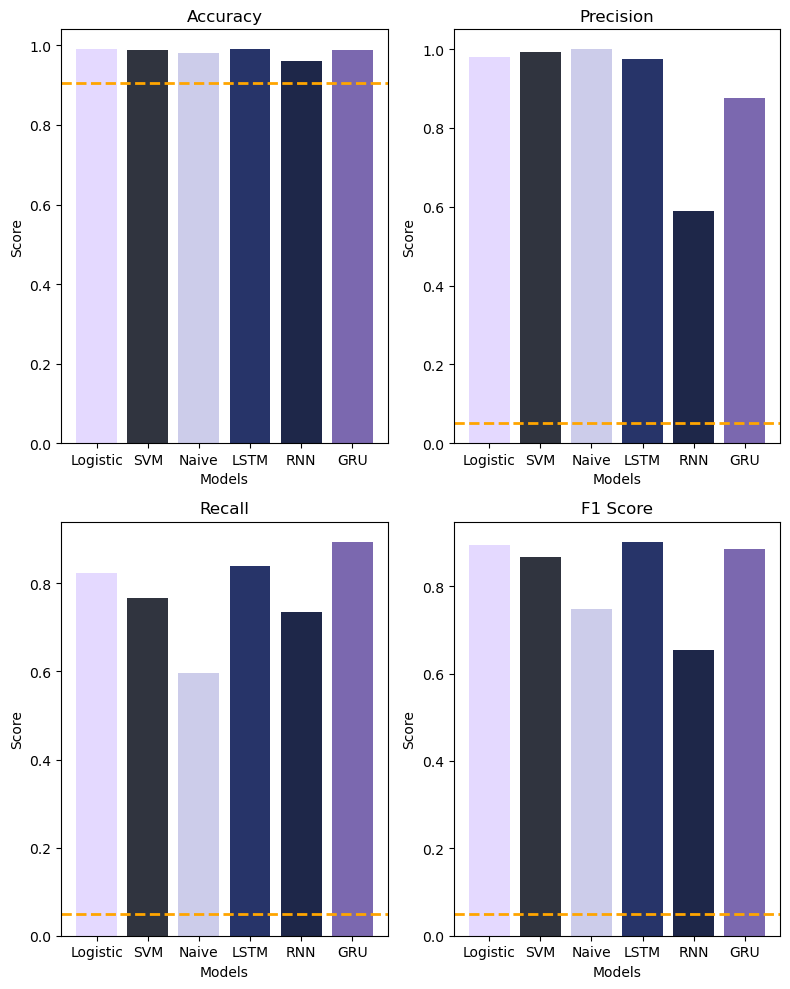

In [191]:
model_performance.at[0, 'Classification models'] = 'Logistic'
model_performance.at[1, 'Classification models'] = 'SVM'
model_performance.at[2, 'Classification models'] = 'Naive'

fig, ((ax_accuracy, ax_precision), (ax_recall, ax_f1)) = plt.subplots(2, 2, figsize=(8, 10))
colors = ['#e4d9ff', '#30343f', '#CCCCEA', '#273469', '#1E2749','#7B68AF']

# Plot accuracy
ax_accuracy.bar(model_performance['Classification models'], model_performance['Accuracy'],color=colors)
ax_accuracy.set_title('Accuracy')
ax_accuracy.set_xlabel('Models')
ax_accuracy.set_ylabel('Score')
ax_accuracy.axhline(y=accuracy,linewidth=2, color='orange', linestyle='--')

# Plot precision
ax_precision.bar(model_performance['Classification models'], model_performance['Precision'],color=colors)
ax_precision.set_title('Precision')
ax_precision.set_xlabel('Models')
ax_precision.set_ylabel('Score')
ax_precision.axhline(y=precision,linewidth=2, color='orange', linestyle='--')

# Plot recall
ax_recall.bar(model_performance['Classification models'], model_performance['Recall'],color=colors)
ax_recall.set_title('Recall')
ax_recall.set_xlabel('Models')
ax_recall.set_ylabel('Score')
ax_recall.axhline(y=recall,linewidth=2, color='orange', linestyle='--')

# Plot f1 
ax_f1.bar(model_performance['Classification models'], model_performance['F1 Score'],color=colors)
ax_f1.set_title('F1 Score')
ax_f1.set_xlabel('Models')
ax_f1.set_ylabel('Score')
ax_f1.axhline(y=f1,linewidth=2, color='orange', linestyle='--')


plt.tight_layout()
plt.show()

The results show that all models achieved precision and recall values above the baseline, with the LSTM model achieving the highest performance with a precision of 97.4% and recall of 83.9%, while also attaining an accuracy of 99.07%. The logistic regression model performed second best with an accuracy of 99.02%, precision of 98% and recall of 82.3%. While logistic regression had a marginally higher precision, the LSTM achieved a better balance between precision and recall, which is important for classification problems to minimize both false positives and false negatives.Therefore, the LSTM model will be chosen to be deployed on my fake job detection website as it attained the highest metrics overall and optimal balance between key performance metrics.

## Saving the best LSTM model

In [211]:
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)
    print("Model successfully saved")

with open('model_weights.pkl', 'wb') as f:
    pickle.dump(lstm_model.weights, f)

INFO:tensorflow:Assets written to: C:\Users\Julie\AppData\Local\Temp\tmpp3usc_hg\assets


INFO:tensorflow:Assets written to: C:\Users\Julie\AppData\Local\Temp\tmpp3usc_hg\assets


Model successfully saved


## Manual testing

In [304]:
# Load model 
with open('lstm_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

# Load weights
with open('model_weights.pkl', 'rb') as f:
    lstm_weights = pickle.load(f)
    
final_model.set_weights(lstm_weights) 
final_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 300, 300)          24652200  
                                                                 
 lstm_1 (LSTM)               (None, 32)                42624     
                                                                 
 dense_80 (Dense)            (None, 32)                1056      
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                                 
 dense_81 (Dense)            (None, 32)                1056      
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_82 (Dense)            (None, 1)               

In [305]:
def preprocess_text(text):
    stop_words=set(stopwords.words('english'))
    lemmatizer=WordNetLemmatizer()
    words=text.lower()
    words=contractions.fix(words)
    words=re.sub(r'[^A-Za-z\s]',' ',words)
    tokens=word_tokenize(words)
    processed_words=[]
    for tk in tokens:
        if tk not in stop_words and len(tk)>1:
            processed_words.append(lemmatizer.lemmatize(tk))
    processed_text=' '.join(processed_words)
    return processed_text


def fraud_job_detection(sample_sentence):
    processed_sample = preprocess_text(sample_sentence)
    if len(processed_sample.split()) < 30:
        return 'Provided information is too little to analyze'
    tokenizer = Tokenizer(num_words=10000, oov_token='<oov>')
    tokenizer.fit_on_texts([processed_sample])
    sequence = tokenizer.texts_to_sequences([processed_sample])
    padded_sequence = pad_sequences(sequence, maxlen=300, padding='post', truncating='post')
    predictions = final_model.predict(padded_sequence)
    if predictions>0.5 : 
        predict='FRAUDULENT'
    else : 
        predict='REAL'
    return predict 

real_job_result = fraud_job_detection('Digital Marketing Specialist,IT Solutions Ltd,UK.IT Solutions Ltd. is a leading provider of innovative software solutions for businesses worldwide. We specialize in delivering cutting-edge technologies to help our clients achieve their digital transformation goals.We are seeking a talented and experienced Digital Marketing Specialist to join our dynamic marketing team. The ideal candidate will be passionate about leveraging digital channels to drive brand awareness, generate leads, and increase customer engagement.Bachelors degree in Marketing, Communications, or related field.Competitive salary and performance-based incentives.Comprehensive health and wellness benefits package.Flexible work hours and remote work options.Fun and collaborative work environment with regular team events and activities.')
print('For Real job sample the model concluded the post is : ', real_job_result) 


1/1 [==============================] - 1s 603ms/step
For Real job sample the model concluded the post is :  REAL


## Integration to website

In [349]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Job Posting Form</title>
</head>
<style>
    body{
        background-color: #273247;
    }
    p{
        text-align: center;
        align-items: center;
    }
    .blue{
        color:#04B4F3
    }
    .red{
        color:#ff0000
    }
    .heading_container{
        width: 80%;
        align-items: center;
        margin: 0 auto;
    }
    h1{
        text-align: center;
        color: #ffffff;
        font-size: 50px;
        border: 3px solid #ffffff;
        padding:5px; 
        border-radius: 40px;
    }  
    .flex-container {
        display: flex;
        padding:10px;
    }
    .form-container {
        background-color: #ffffff;
        width:80%;
        height:80%;
        border-radius:20px;
        margin:auto;
        padding:10px;
        background-color: #77879D;
    }

    label {
        display: block;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 20px;
        
    }
    .box_label1{
        margin:10px 0px 0px 10px;
    }
    .row1_box{
        margin:0px 50px;
    }
    .box_label2{
        margin:5px 5px 0px 5px;
        text-align: center;
    }
    .row2_box{
        margin:0px 20px;   
    }

    .box_label3{
        margin:40px 20px 0px 5px;
    }
    .row3_box{
        margin:0px 20px;   
    }
    .box_label4{
        margin:40px 5px 0px 5px;
    }
    input[type="text"],
    select,
    textarea {
        width: 20%;
        padding: 8px;
        margin-bottom: 10px;
        border: 1px solid #ccc;
        border-radius: 4px;
        box-sizing: border-box;
        border-radius: 10px;
    }
    .parent-container {
    text-align: center;
    }

    input[type="submit"] {
        background-color: #4CAF50;
        color: white;
        padding: 10px 20px;
        border: none;
        border-radius: 4px;
        cursor: pointer;
        margin:auto;
        width: 200px;
        border-radius: 20px;
    }

    textarea {
        width: 300px; 
        height: 110px; 
        padding: 5px; 
        resize: vertical; 
    }

</style>
<body>
    <div class="heading_container">
    <h1>Check if Job Posting is
        <span class="blue">Real</span> or
        <span class="red">Fake</span> !
    </h1>
    </div>
    <form action="/prediction_result" method="POST">
        <div class="form-container">
            <p>Add in the Job post details</p>
            <div class="flex-container">
                <label class='box_label1' for="title">Title:</label>
                <input class='row1_box' type="text" id="title" name="title">
            
                <label class='box_label1' for="industry">Industry:</label>
                <input class='row1_box' type="text" id="industry" name="industry">
            
                <label class='box_label1' for="country">Country:</label>
                <input class='row1_box' type="text" id="country" name="country">
            </div>

            <div class="flex-container">
            <label class='box_label2' for="department">Department:</label><br>
            <input class='row2_box' type="text" id="department" name="department"><br>

            <label class='box_label2' for="employment_type">Employment Type:</label><br>
            <select  class='row2_box' id="employment_type" name="employment_type">
                <option value="Full-time">Full-time</option>
                <option value="Part-time">Part-time</option>
                <option value="Contract">Contract</option>
                <option value="Temporary">Temporary</option>
                <option value="Other">Other</option>
                <option value="Unknown" selected >Unknown</option>

            </select><br>

            <label class='box_label2' for="required_experience">Required Experience:</label><br>
            <select  class='row2_box'  id="required_experience" name="required_experience">
                <option value="Internship">Internship</option>
                <option value="Not Applicable">Not Applicable</option>
                <option value="Mid-Senior level">Mid-Senior level</option>
                <option value="Associate">Associate</option>
                <option value="Entry level">Entry level</option>
                <option value="Executive">Executive</option>
                <option value="Director">Director</option>
                <option value="Unknown" selected>Unknown</option>
            </select><br>
            </div>

            <div class="flex-container">
            <label class='box_label3' for="company_profile">Company Profile:</label><br>
            <textarea class='row3_box' id="company_profile" name="company_profile"></textarea><br>

            <label class='box_label3' for="job_description">Job Description:</label><br>
            <textarea class='row3_box' id="job_description" name="job_description"></textarea><br>
            </div>

            <div class="flex-container">
            <label class='box_label4' for="requirements">Requirements:</label><br>
            <textarea id="requirements" name="requirements"></textarea><br>

            <label class='box_label4' for="benefits">Benefits:</label><br>
            <textarea id="benefits" name="benefits"></textarea><br>

            <label class='box_label4' for="function">Function:</label><br>
            <textarea type="text" id="function" name="function"></textarea><br>
            </div>
            <div class="parent-container">
                <input type="submit" value="Check ✅">
            </div>
        </div>
    </form>
</body>
</html>%%writefile templates/prediction_result.html<!DOCTYPE html>

Overwriting templates/index.html


In [350]:
%%writefile templates/prediction_result.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Job Posting Classification Result</title>
    <style>
        body {
            display: flex;
            flex-direction: column;
            justify-content: center;
            align-items: center;
            height: 100%;
            margin: 0;
            background-color: #273247;
        }  
        h1 {
          text-align: center;
          color: #ffffff;
          font-size: 50px;
          margin-top: 0px;
          padding: 20px;
        }

        .result-container {
          text-align: center;
          color: #ffffff;
          font-size: 48px;
          margin-top: 20px;
        }

        .result {
          color: #273247;
        }

        .result.real {
          color: blue; 
        }

        .result.fraudulent {
          color: red;
        }
        button {
          background-color: #ffffff;
          color: #273247;
          border: none;
          border-radius: 50px;
          width: 100px;
          height: 30px;
          font-size: 16px;
          cursor: pointer;
          margin-top: 20px;
        }
    </style>
</head>
<body>
    <h1>Job Posting Classification Result</h1> 
    <div class="result-container">
        <p>The job posting is: <strong>{{ result }}</strong></p>
    </div>
    <button onclick="goBack()">Go Back</button>
    
    <script>
        function goBack() {
            window.history.back();
        }
    </script>
</body>
</html>


Overwriting templates/prediction_result.html


In [ ]:
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/prediction_result', methods=['POST'])
def predict():
    if request.method == 'POST':
        title = request.form['title']
        industry = request.form['industry']
        country = request.form['country']
        department = request.form['department']
        employment_type = request.form['employment_type']
        required_experience = request.form['required_experience']
        company_profile = request.form['company_profile']
        job_description = request.form['job_description']
        requirements = request.form['requirements']
        benefits = request.form['benefits']
        function = request.form['function']

        analyze_job_details = f"{title} {industry} {country} {department} {employment_type} {required_experience} {company_profile} {job_description} {requirements} {benefits} {function}"
        result = fraud_job_detection(analyze_job_details)
        return render_template('prediction_result.html', result=result)
    
if __name__ == '__main__':
    app.run(debug=False,port=2001)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:2001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [11/Mar/2024 09:36:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Mar/2024 09:36:34] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 98ms/step


INFO:werkzeug:127.0.0.1 - - [11/Mar/2024 09:37:37] "POST /prediction_result HTTP/1.1" 200 -
